In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Flatten, Dropout
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load Dataset
data = pd.read_csv('/content/drive/MyDrive/AnalyticsCAPSTONEDataset/2024/merged_cleaned_data_2024.csv')
# data = pd.read_csv('merged_cleaned_data.csv')

In [ ]:
# Display basic information
print("Merged Data Shape:", data.shape)
print("Columns:", data.columns)

Merged Data Shape: (23408996, 8)
Columns: Index(['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count',
       'trip_distance', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'fare_amount'],
      dtype='object')


In [ ]:
# Convert datetime columns
data['tpep_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'])
data['tpep_dropoff_datetime'] = pd.to_datetime(data['tpep_dropoff_datetime'])

# Add trip duration in hours
data['trip_duration_hours'] = (data['tpep_dropoff_datetime'] - data['tpep_pickup_datetime']).dt.total_seconds() / 3600

# Data Cleaning Steps
data_cleaned = data[
    (data['trip_duration_hours'] <= 12) &
    (data['fare_amount'] <= 1000) &
    (data['trip_distance'] <= 23)
]

# Calculate speed
data_cleaned['average_speed_mph'] = data_cleaned['trip_distance'] / data_cleaned['trip_duration_hours']
data_cleaned = data_cleaned[data_cleaned['average_speed_mph'] <= 45.31]

# Clustering (Pickup Lat/Long as features)
pickup_coords = data_cleaned[['PULocationID', 'DOLocationID']]
scaler = MinMaxScaler()
pickup_coords_scaled = scaler.fit_transform(pickup_coords)

kmeans = KMeans(n_clusters=40, random_state=42)
data_cleaned['cluster'] = kmeans.fit_predict(pickup_coords_scaled)

# Time Binning (10-minute intervals)
data_cleaned['time_bin'] = (
    data_cleaned['tpep_pickup_datetime'].dt.hour * 6 +
    data_cleaned['tpep_pickup_datetime'].dt.minute // 10
)

<ipython-input-7-eb5bd47920e5>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['average_speed_mph'] = data_cleaned['trip_distance'] / data_cleaned['trip_duration_hours']


In [ ]:
# Count the number of rows in the DataFrame after cleaning
num_rows = data.shape[0]

print(f"The number of rows in the DataFrame is: {num_rows}")

The number of rows in the DataFrame is: 23408996


In [ ]:
data.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,fare_amount,trip_duration_hours
0,2024-04-01 00:02:40,2024-04-01 00:30:42,0.0,5.20,1.0,161,7,29.6,0.467222
1,2024-04-01 00:41:12,2024-04-01 00:55:29,1.0,5.60,1.0,264,264,25.4,0.238056
2,2024-04-01 00:48:42,2024-04-01 01:05:30,1.0,3.55,1.0,186,236,20.5,0.280000
3,2024-04-01 00:56:02,2024-04-01 01:05:09,1.0,1.06,1.0,137,164,10.0,0.151944
4,2024-04-01 00:08:32,2024-04-01 00:10:24,1.0,0.70,1.0,236,263,5.1,0.031111


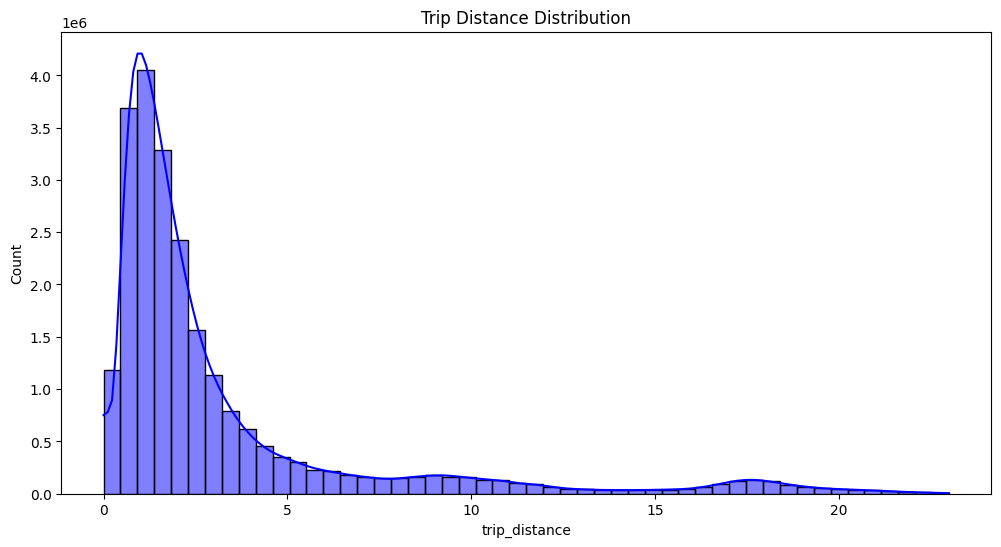

In [ ]:
# EDA
plt.figure(figsize=(12, 6))
sns.histplot(data_cleaned['trip_distance'], kde=True, bins=50, color='blue')
plt.title('Trip Distance Distribution')
plt.show()

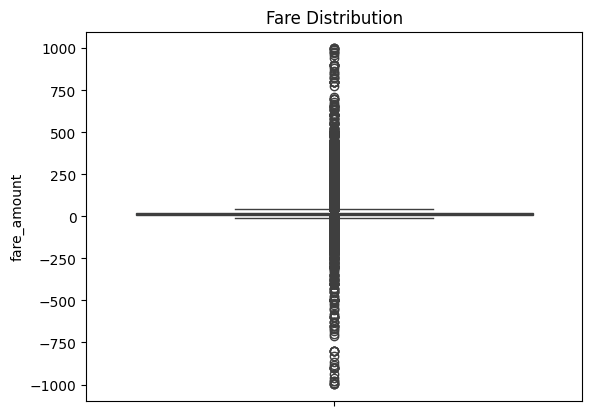

In [ ]:
sns.boxplot(data_cleaned['fare_amount'])
plt.title('Fare Distribution')
plt.show()

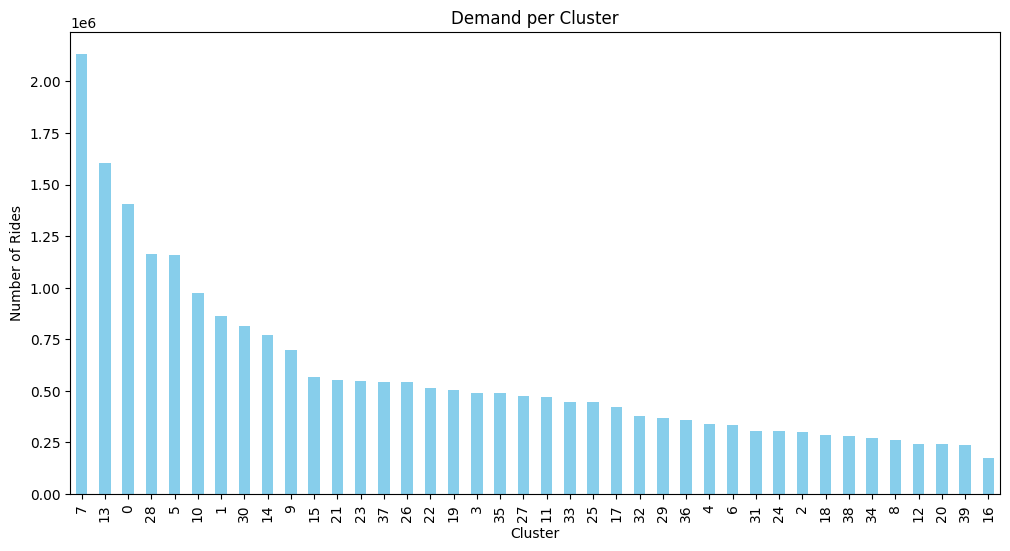

In [ ]:
# Cluster-wise demand distribution
cluster_demand = data_cleaned.groupby('cluster').size()
plt.figure(figsize=(12, 6))
cluster_demand.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Demand per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Rides')
plt.show()

In [ ]:
# Time-series demand data preparation
time_series = data_cleaned.groupby(['time_bin', 'cluster']).size().reset_index(name='demand')
time_series_pivot = time_series.pivot(index='time_bin', columns='cluster', values='demand').fillna(0)

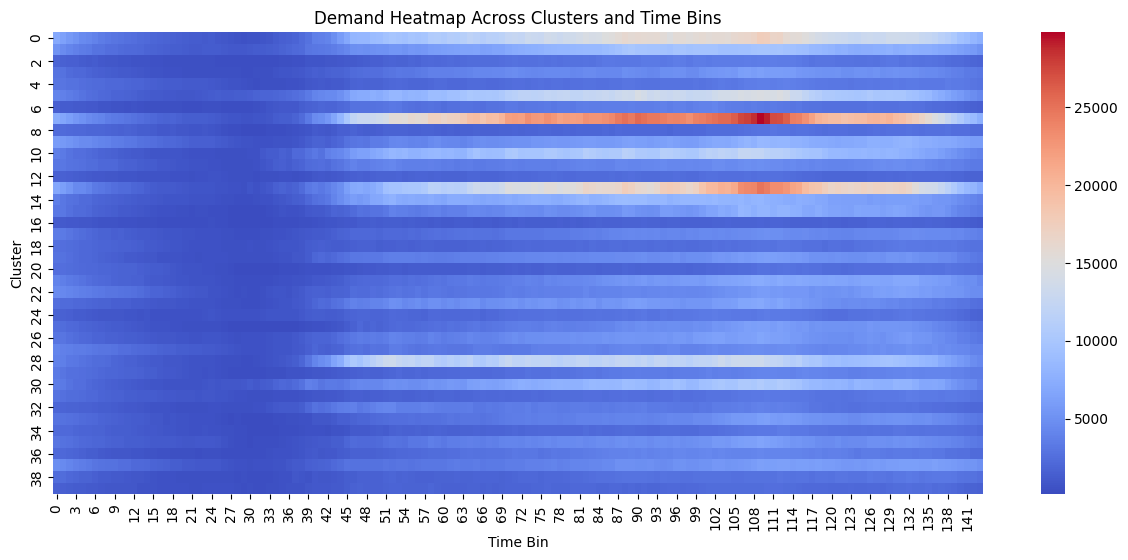

In [ ]:
# Time-bin demand heatmap
heatmap_data = time_series.pivot(index='time_bin', columns='cluster', values='demand').fillna(0)
plt.figure(figsize=(15, 6))
sns.heatmap(heatmap_data.T, cmap='coolwarm', cbar=True)
plt.title('Demand Heatmap Across Clusters and Time Bins')
plt.xlabel('Time Bin')
plt.ylabel('Cluster')
plt.show()

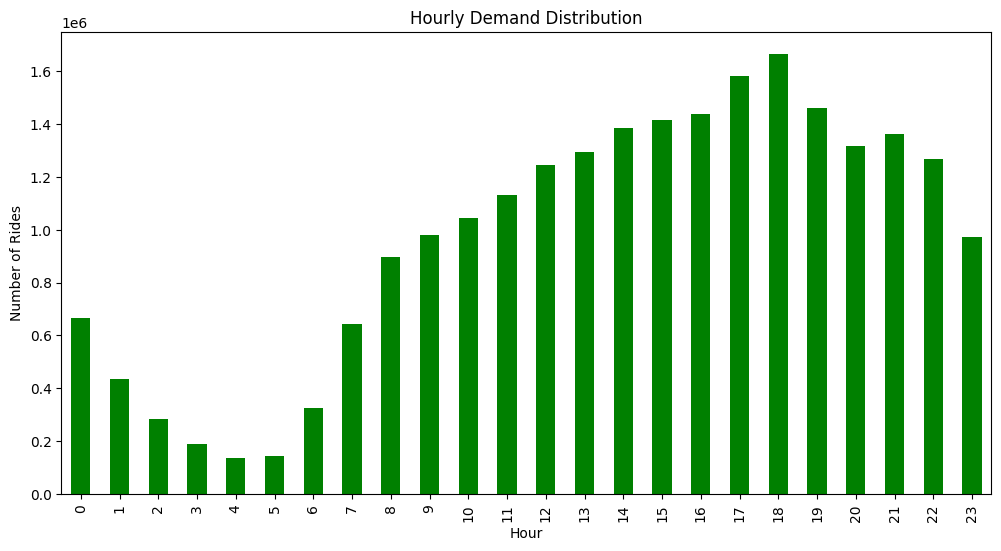

In [ ]:
# Hourly Demand
data_cleaned['pickup_hour'] = data_cleaned['tpep_pickup_datetime'].dt.hour
hourly_demand = data_cleaned.groupby('pickup_hour').size()
plt.figure(figsize=(12, 6))
hourly_demand.plot(kind='bar', color='green')
plt.title('Hourly Demand Distribution')
plt.xlabel('Hour')
plt.ylabel('Number of Rides')
plt.show()

In [ ]:
# Create training data for LSTM-CNN
sequence_length = 10
data_X, data_y = [], []

for i in range(sequence_length, len(time_series_pivot)):
    data_X.append(time_series_pivot.values[i-sequence_length:i, :])
    data_y.append(time_series_pivot.values[i, :])

data_X, data_y = np.array(data_X), np.array(data_y)

# Train-Test Split
train_size = int(0.7 * len(data_X))
X_train, X_test = data_X[:train_size], data_X[train_size:]
y_train, y_test = data_y[:train_size], data_y[train_size:]

In [ ]:
# Normalize the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Advanced Model: Bidirectional LSTM + CNN
model = Sequential([
    Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
    Dropout(0.4),
    Bidirectional(LSTM(128, activation='relu', return_sequences=True)),
    Dropout(0.4),
    Bidirectional(LSTM(64, activation='relu')),
    Dense(40, activation='relu'),
])

# Compile with a smaller learning rate
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

# Use improved callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6)

# Train the model
history = model.fit(
    X_train_scaled, y_train,
    epochs=200,
    batch_size=64,
    validation_data=(X_test_scaled, y_test),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 737ms/step - loss: 26406190.0000 - val_loss: 50428368.0000 - learning_rate: 5.0000e-04
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 25807800.0000 - val_loss: 50426296.0000 - learning_rate: 5.0000e-04
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 26619822.0000 - val_loss: 50421696.0000 - learning_rate: 5.0000e-04
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 27256480.0000 - val_loss: 50409436.0000 - learning_rate: 5.0000e-04
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 27098964.0000 - val_loss: 50369188.0000 - learning_rate: 5.0000e-04
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 27461634.0000 - val_loss: 50252880.0000 - learning_rate: 5.0000e-04
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 27101760.0000 - val_loss: 49975364.0000 - learning_rate: 5.0000e-04
Epoch 8/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 26223026.0000 - val_loss: 49331072.0000 - learning_rate: 5.0000e-04
Ep

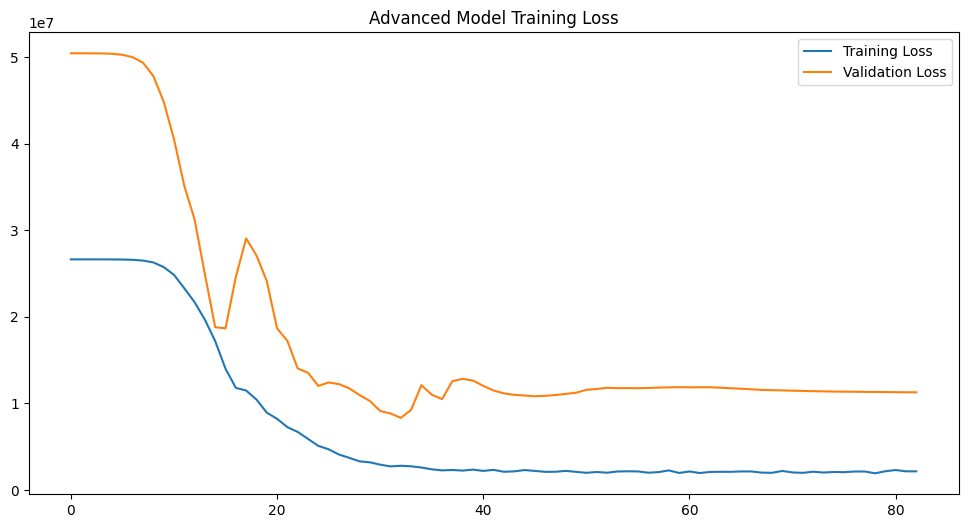

In [ ]:
# Training Loss Plot
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Advanced Model Training Loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate
predictions = model.predict(X_test_scaled)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mape = mean_absolute_percentage_error(y_test, predictions)
print(f"Advanced RMSE: {rmse:.2f}")
print(f"Advanced MAPE: {mape:.2%}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 652ms/step
Advanced RMSE: 2886.57
Advanced MAPE: 38.56%


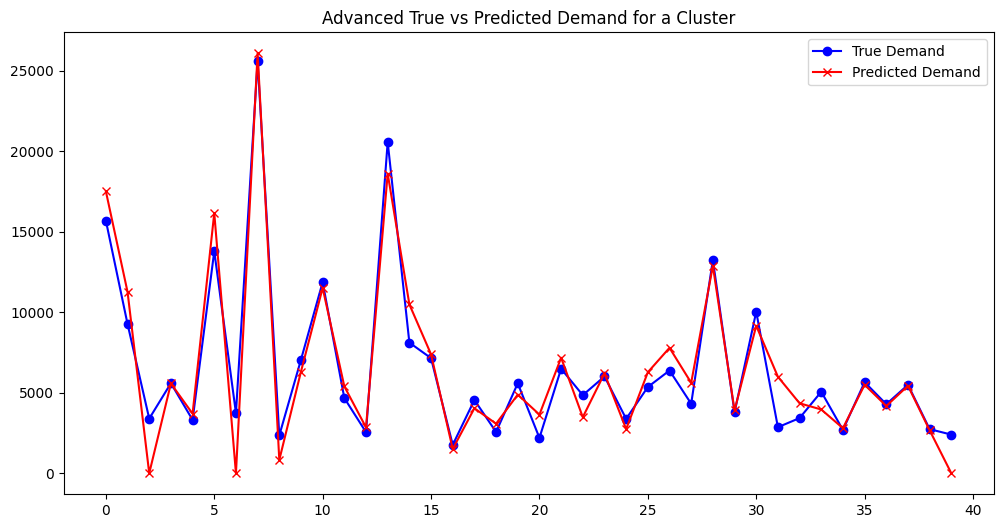

In [ ]:
# Visualize Predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test[0], label='True Demand', marker='o', color='blue')
plt.plot(predictions[0], label='Predicted Demand', marker='x', color='red')
plt.legend()
plt.title('Advanced True vs Predicted Demand for a Cluster')
plt.show()